# Introduction
This notebook provides a comprehensive analysis of mobile device usage patterns and user behavior classification.
We will preprocess the data, perform exploratory data analysis, engineer features, train a machine learning model,
and evaluate its performance.

## 1. import

### 1.1 Import libraries

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import pickle 

# scikit learn libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction import DictVectorizer



### 1.2 Import data

In [3]:
# defining the path to the data
path = 'data/'
output_path = 'output/'

In [4]:
# import data
data = pd.read_csv(path + 'user_behavior_dataset.csv')

In [5]:
# showing the 5 random rows of the data
data.sample(5)

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
449,450,Google Pixel 5,Android,34,1.2,518,10,170,20,Female,1
528,529,Google Pixel 5,Android,175,3.0,801,32,338,24,Male,2
573,574,Samsung Galaxy S21,Android,537,9.1,2858,86,2158,22,Male,5
341,342,iPhone 12,iOS,597,10.3,2718,90,1863,26,Female,5
369,370,iPhone 12,iOS,165,2.4,816,35,503,34,Male,2


In [6]:
# normalizing names of the columns
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [7]:
# Function to sanitize file names
def sanitize_filename(name):
    return re.sub(r'[^\w\-_\. ]', '_', name)

In [8]:
# Function to identify outliers
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

## 2. EDA

### 2.1  Checking the dataset

In [9]:
# searching for null values in the data
data.isnull().sum()

user_id                       0
device_model                  0
operating_system              0
app_usage_time_(min/day)      0
screen_on_time_(hours/day)    0
battery_drain_(mah/day)       0
number_of_apps_installed      0
data_usage_(mb/day)           0
age                           0
gender                        0
user_behavior_class           0
dtype: int64

In [10]:
# checking the data types of the columns
data.dtypes

user_id                         int64
device_model                   object
operating_system               object
app_usage_time_(min/day)        int64
screen_on_time_(hours/day)    float64
battery_drain_(mah/day)         int64
number_of_apps_installed        int64
data_usage_(mb/day)             int64
age                             int64
gender                         object
user_behavior_class             int64
dtype: object

In [11]:
# checking the devices models
print(data.device_model.unique())

['Google Pixel 5' 'OnePlus 9' 'Xiaomi Mi 11' 'iPhone 12'
 'Samsung Galaxy S21']


In [12]:
print(data.operating_system.unique())

['Android' 'iOS']


In [11]:
# defining numerical features
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'user_id' in numerical_features:
    numerical_features.remove('user_id')
    
# defining categorical features
categorical_features = data.select_dtypes(include=[object]).columns.tolist()

In [12]:
# Remove the 'user_id' column
data = data.drop(columns=['user_id'])

# Convert data to a list of dictionaries
data_dict = data.to_dict(orient='records')

In [13]:
# Convert data to a list of dictionaries
# data_dict = data.to_dict(orient='records')

In [14]:
# Initialize and fit DictVectorizer
vec = DictVectorizer(sparse=False)
data_vectorized = vec.fit_transform(data_dict)

Number of outliers detected in app_usage_time_(min/day): 0


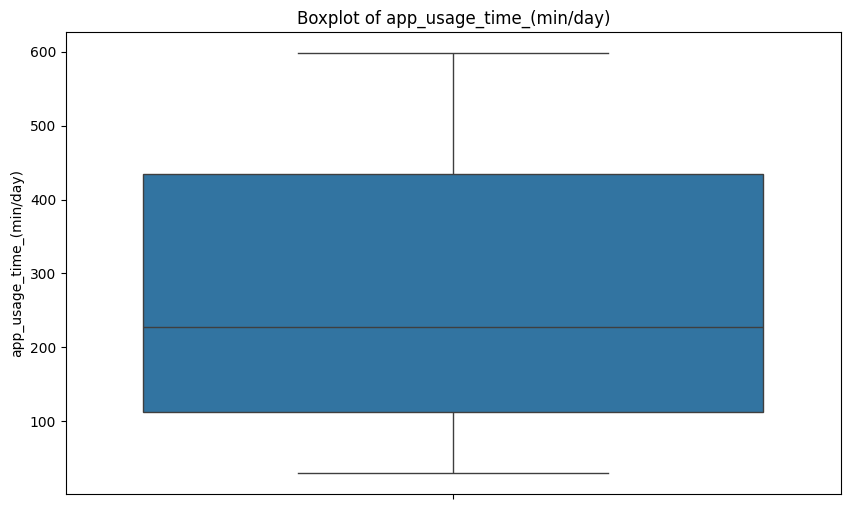

Number of outliers detected in screen_on_time_(hours/day): 0


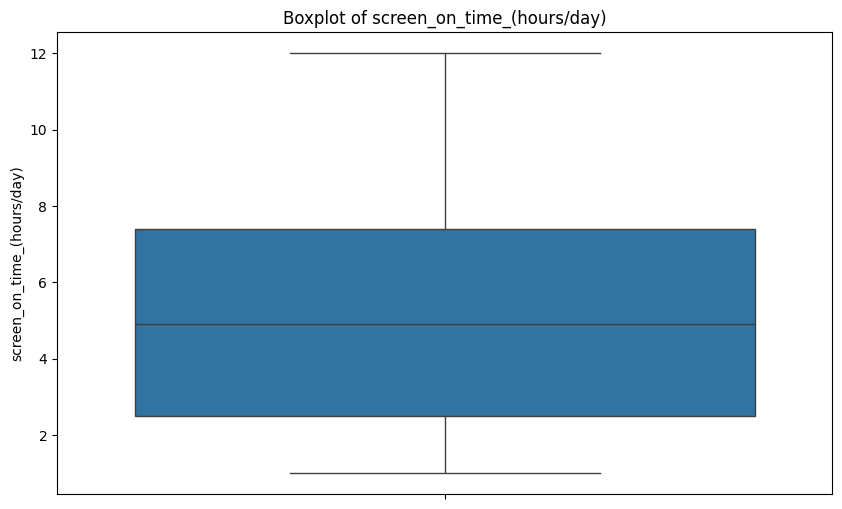

Number of outliers detected in battery_drain_(mah/day): 0


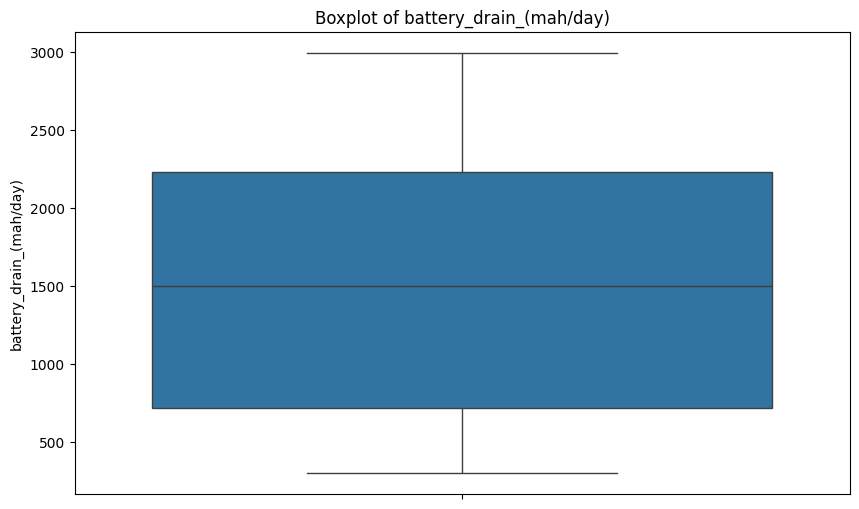

Number of outliers detected in number_of_apps_installed: 0


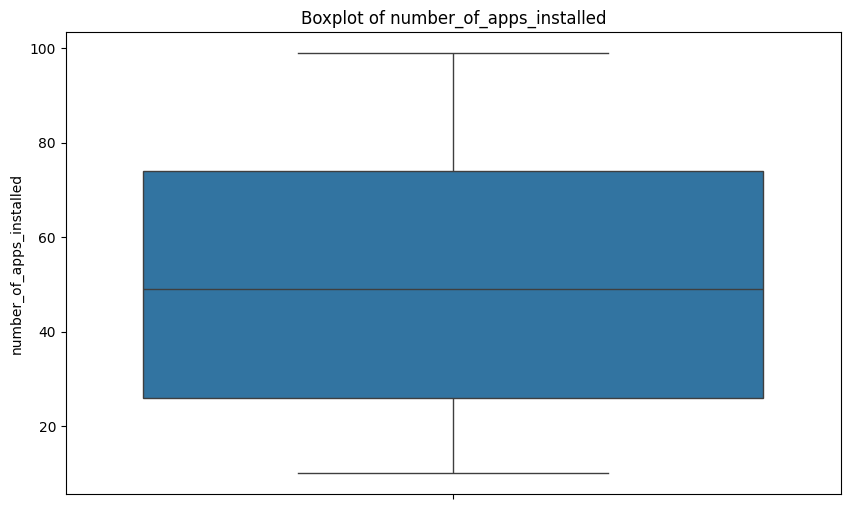

Number of outliers detected in data_usage_(mb/day): 0


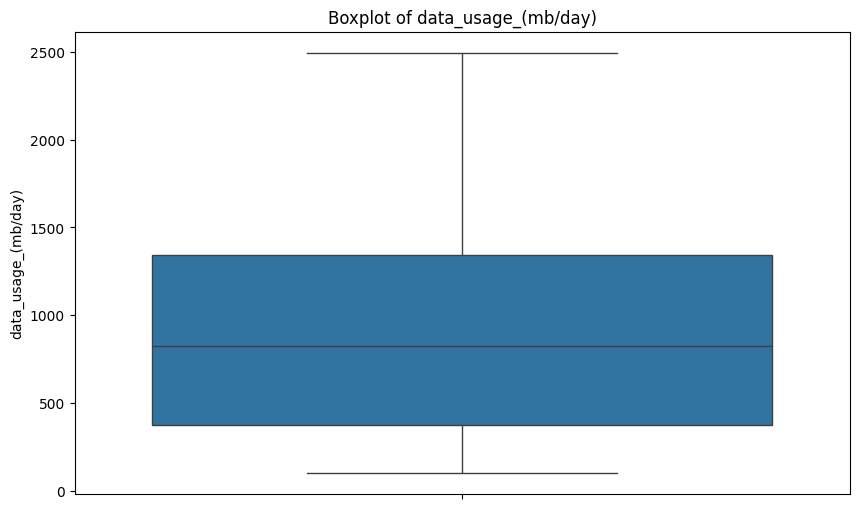

Number of outliers detected in age: 0


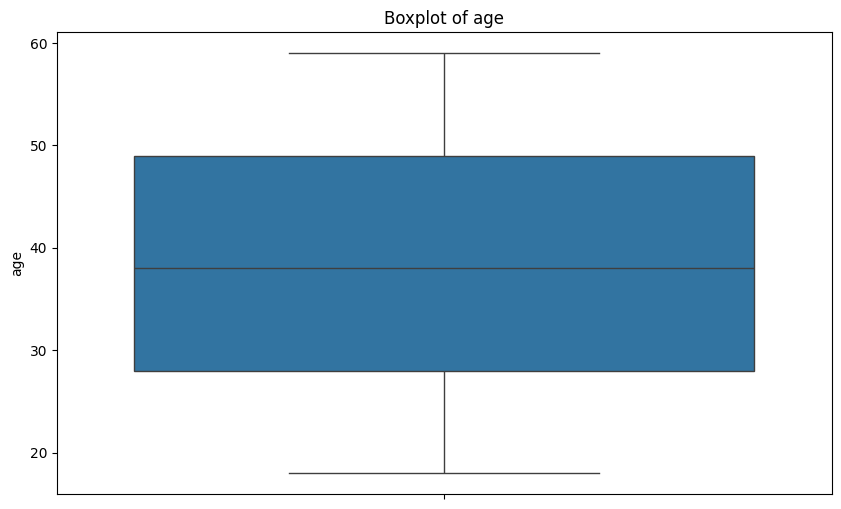

Number of outliers detected in user_behavior_class: 0


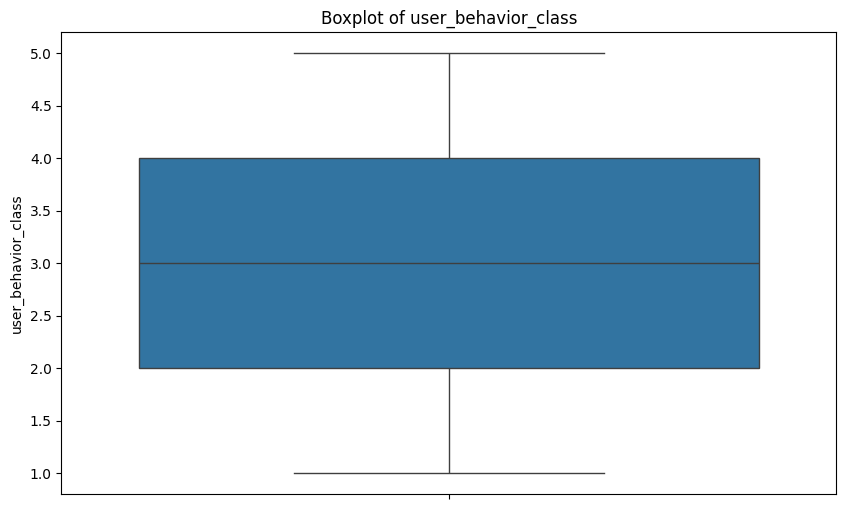

In [15]:

# Loop through each numerical column in the dataframe
numerical_columns = data.select_dtypes(include=[np.number]).columns

for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    
    # Create a boxplot
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    
    # Identify outliers
    outliers = identify_outliers(data, column)
    num_outliers = outliers.shape[0]
    
    # Print the number of outliers detected
    print(f'Number of outliers detected in {column}: {num_outliers}')
    
    # Sanitize the column name for the file name
    sanitized_column = sanitize_filename(column)
    
    # Save the plot
    output_file = os.path.join(output_path, f'{sanitized_column}_boxplot.png')
    plt.savefig(output_file)
    
    # Show the plot
    plt.show()

In [16]:
# checking number of distinct values
data.nunique()

device_model                    5
operating_system                2
app_usage_time_(min/day)      387
screen_on_time_(hours/day)    108
battery_drain_(mah/day)       628
number_of_apps_installed       86
data_usage_(mb/day)           585
age                            42
gender                          2
user_behavior_class             5
dtype: int64

### 2.2 Checking correlations

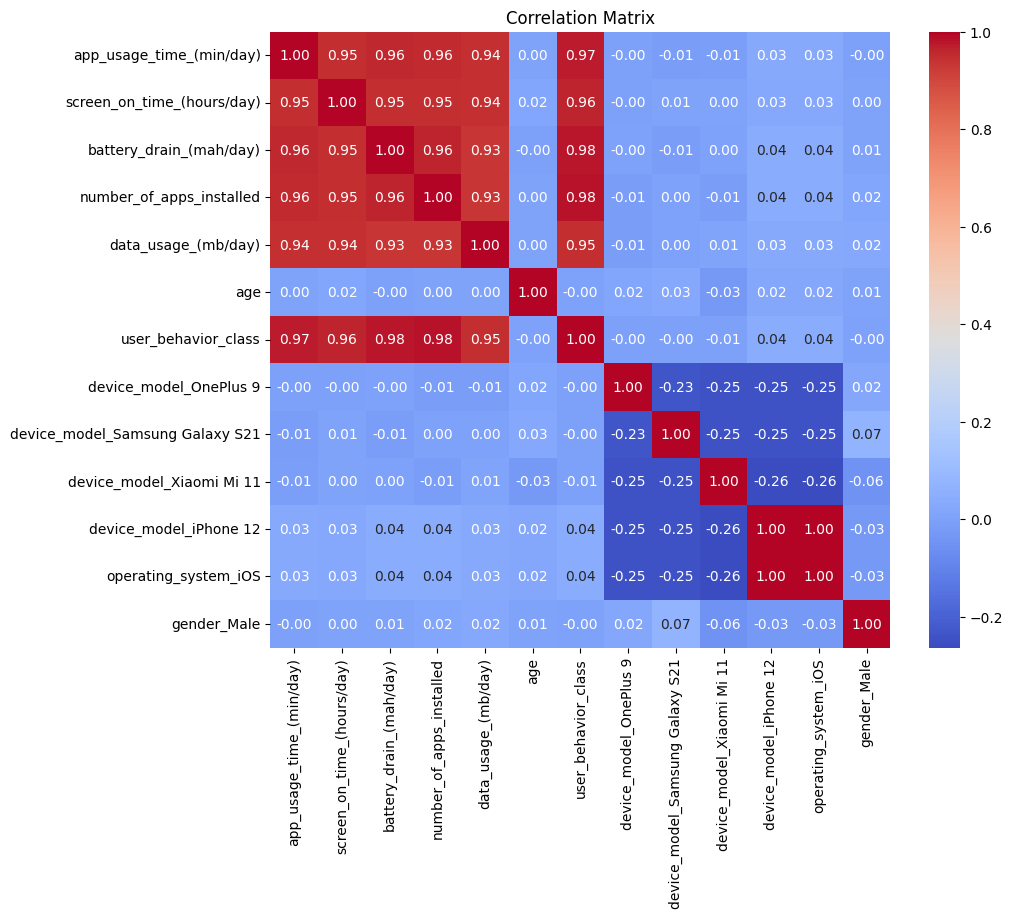

In [17]:
# Convert categorical features to numerical using one-hot encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = data_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [18]:
# Calculate correlation with age
correlation_with_user_behavior_class = data[numerical_features].corrwith(data['user_behavior_class'])

# Display the correlation with age
print(correlation_with_user_behavior_class)

app_usage_time_(min/day)      0.970498
screen_on_time_(hours/day)    0.964581
battery_drain_(mah/day)       0.978587
number_of_apps_installed      0.981255
data_usage_(mb/day)           0.946734
age                          -0.000563
user_behavior_class           1.000000
dtype: float64


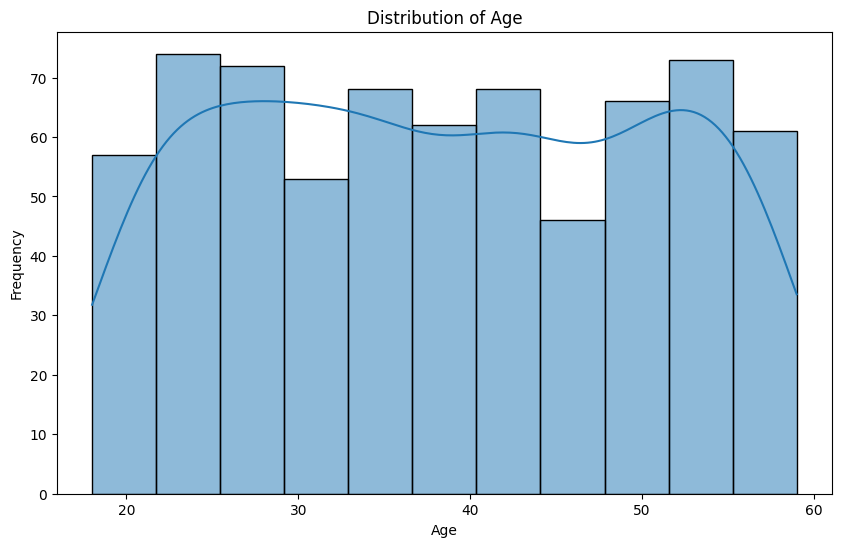

In [19]:
# Plotting the distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

#saving the plot
output_file = os.path.join(output_path, 'age_distribution.png')
plt.savefig(output_file)

#showing the result
plt.show()


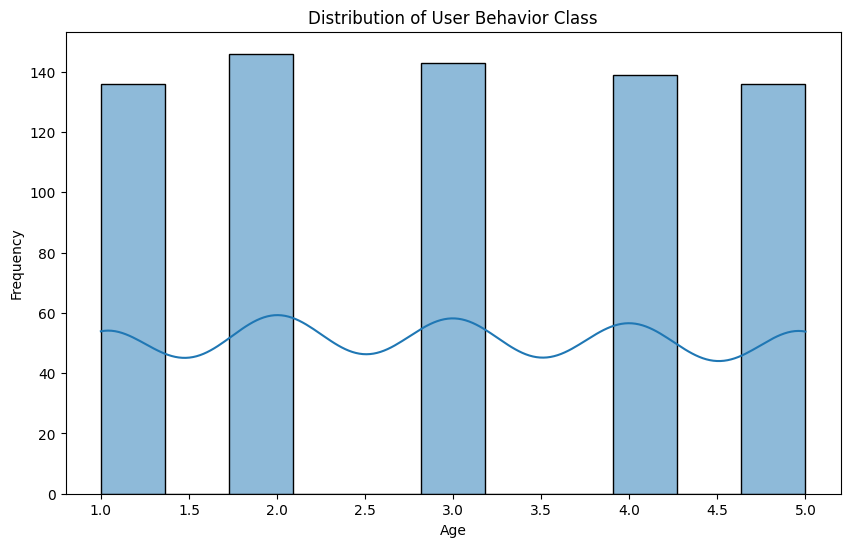

In [20]:
# Plotting the distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(data['user_behavior_class'], kde=True)
plt.title('Distribution of User Behavior Class')
plt.xlabel('Age')
plt.ylabel('Frequency')

#saving the plot
output_file = os.path.join(output_path, 'user_behavior_distribution.png')
plt.savefig(output_file)

#showing the result
plt.show()

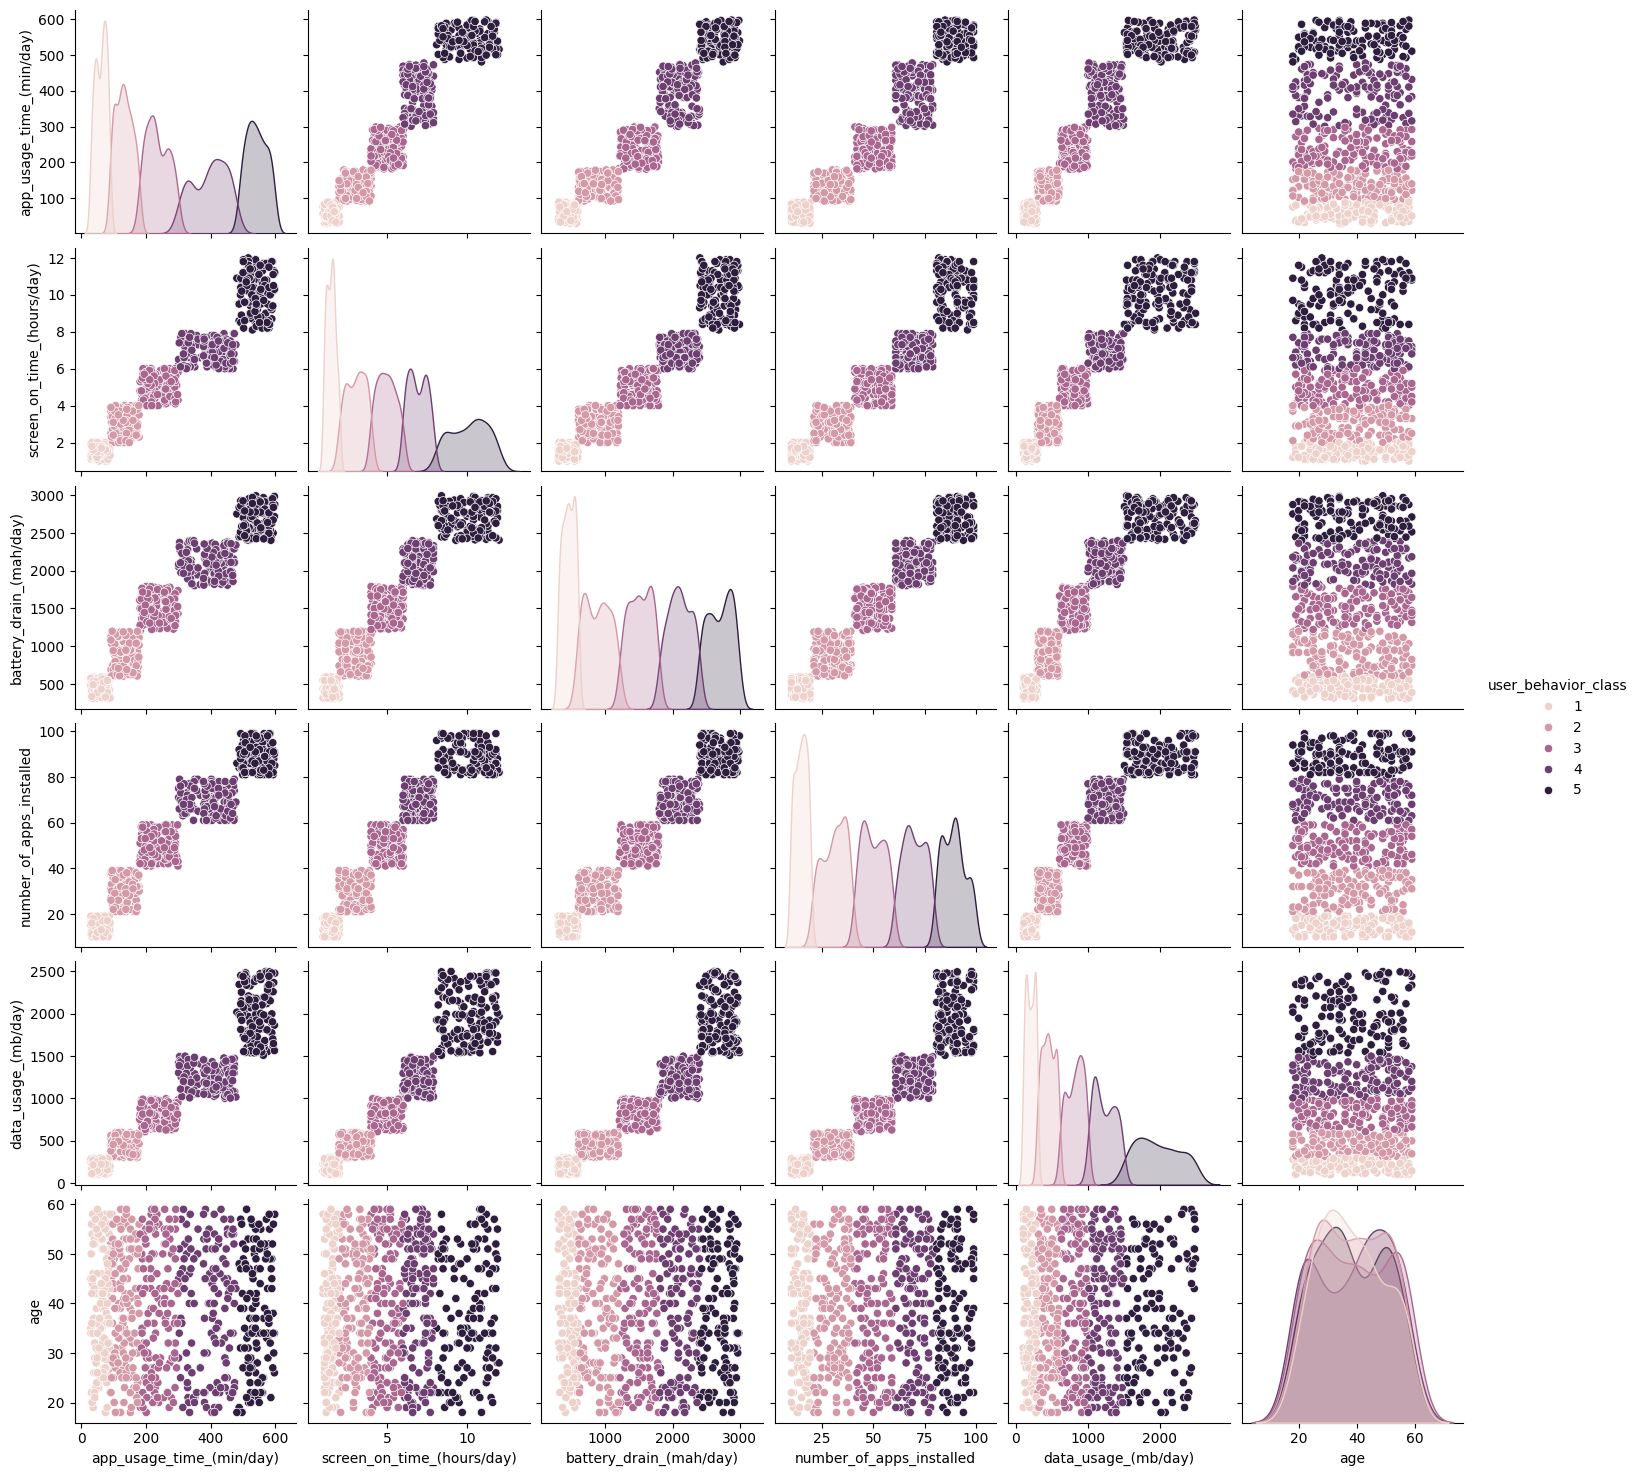

In [21]:
# looking at the relationship with the target variable
sns.pairplot(data, hue='user_behavior_class', diag_kind='kde')
#saving the plot
output_file = os.path.join(output_path, 'pairplot_user_distriution.png')
plt.savefig(output_file)

plt.show()

## 3. Data Modelling

In [22]:
# Features and target
X = data_vectorized
y = data['user_behavior_class']

In [23]:
# Define the models
models = {
    'RandomForest': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor()
}

In [24]:
# Create a pipeline
pipeline = Pipeline(steps=[
    ('model', RandomForestRegressor()) 
])

In [25]:
# Define the parameter grid
param_grid = [
    {'model': [models['RandomForest']]},
    {'model': [models['LinearRegression']]},
    {'model': [models['DecisionTree']]},
    {'model': [models['XGBoost']]}
]

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Use GridSearchCV to find the best model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', RandomForestRegressor())]),
             param_grid=[{'model': [RandomForestRegressor()]},
                         {'model': [LinearRegression()]},
                         {'model': [DecisionTreeRegressor()]},
                         {'model': [XGBRegressor(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_sto...
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...)]}],
             scoring='neg_mean_squared_error')

In [28]:
# Get the best model
best_model = grid_search.best_estimator_

In [29]:
# Predict with the best model
predictions = best_model.predict(X_test)

# Print the best model and its score
print(f"Best model: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best model: {'model': DecisionTreeRegressor()}
Best score: 0.0


In [30]:
# Calculate RMSE
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
# Calculate R² score
r2 = r2_score(y_test, predictions)

# Print the best model, its score, and RMSE, R² score
print(f"Best model: {grid_search.best_params_}")
print(f"Best score (neg_mean_squared_error): {grid_search.best_score_}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2}")

Best model: {'model': DecisionTreeRegressor()}
Best score (neg_mean_squared_error): 0.0
RMSE: 0.0
R² score: 1.0


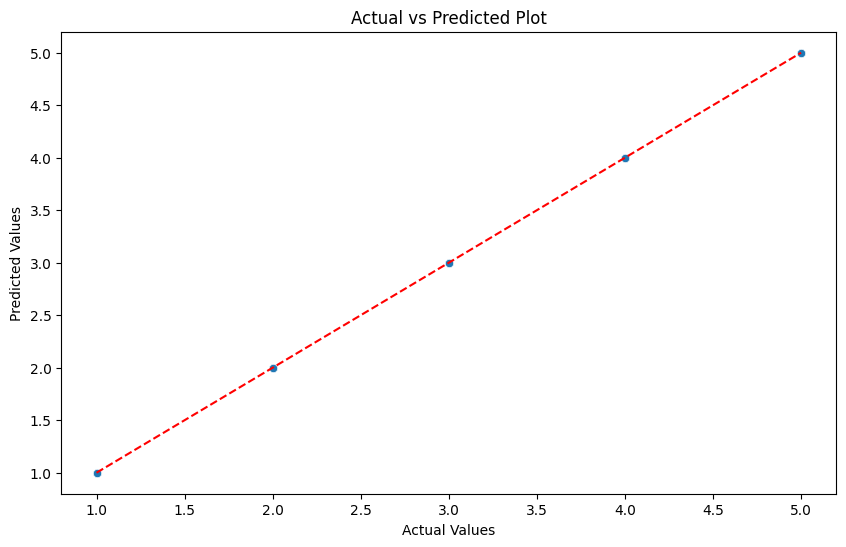

In [31]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Plot')
plt.show()

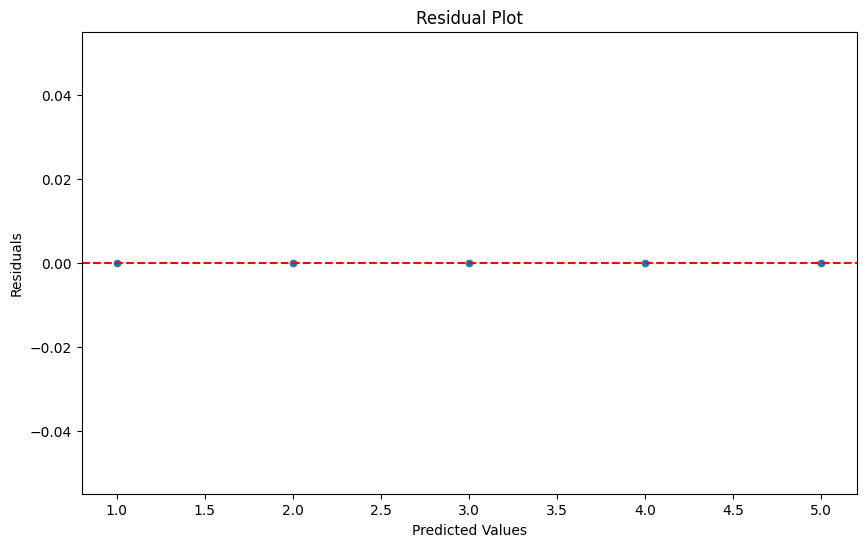

In [32]:
# Calculate residuals
residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

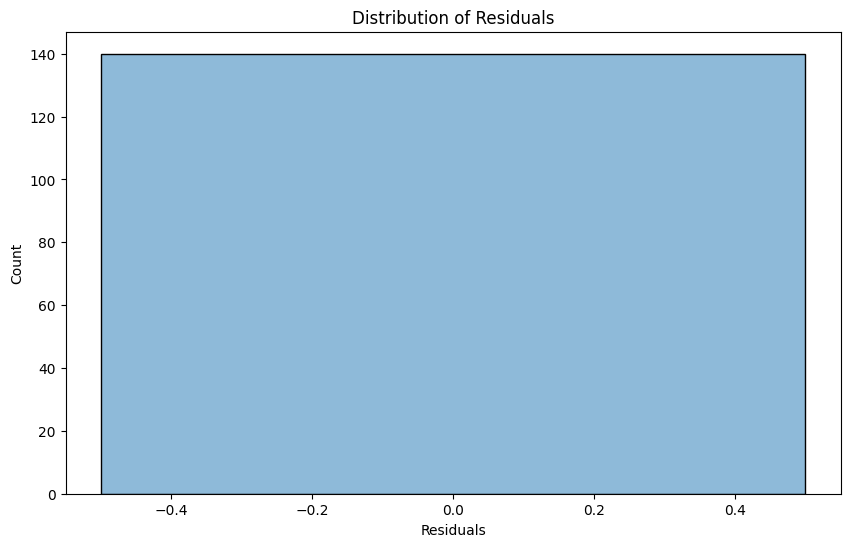

In [33]:
# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

In [34]:
# Save the DictVectorizer to a file
vectorizer_filename = 'vectorizer.pkl'
with open(vectorizer_filename, 'wb') as file:
    pickle.dump(vec, file)

# Save the best model to a file
model_filename = 'model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"DictVectorizer saved to {vectorizer_filename}")
print(f"Best model saved to {model_filename}")

DictVectorizer saved to vectorizer.pkl
Best model saved to model.pkl
